In [46]:
import pandas as pd
import numpy as np
import re
import emoji
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


In [47]:
# Function to check if a line starts with date and time format
def startsWithDateAndTime(s):
    pattern = r"^\[?(\d{1,2})[/](\d{1,2})[/](\d{2,4}),?\s*(\d{1,2}):(\d{2})(\s*[APap][mM])?[\]]?\s*-"
    result = re.match(pattern, s)
    return result


In [48]:
# Function to check if a line contains author information
def FindAuthor(s):
    return re.match(r'^.*:', s)


In [49]:
# Function to extract date, time, author, and message from a line
def getDataPoint(line):
    splitLine = line.split(' - ')
    dateTime = splitLine[0]
    date, time = dateTime.split(', ')
    message = ' '.join(splitLine[1:])
    
    if FindAuthor(message):
        splitMessage = message.split(': ')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    
    return date, time, author, message


In [50]:
# Function to split and count emojis in a text
def split_count(text):
    emoji_list = [emoji.demojize(e) for e in emoji.distinct_emoji_list(text)]
    return emoji_list


In [51]:
# File path for WhatsApp chat export
file_path = '/Users/surajojha/Downloads/watsaap group data analysis/WhatsApp Chat with +91 77719 74705 copy.txt'


In [52]:
# Initialize lists to store parsed data
parsedData = []
conversation = file_path

In [53]:
# Read the WhatsApp chat file and parse the data
with open(conversation, encoding="utf-8") as fp:
    fp.readline()  # Skipping first line of the file
    
    messageBuffer = []
    date, time, author = None, None, None
    
    while True:
        line = fp.readline()
        if not line:
            break
        
        line = line.strip()
        
        if startsWithDateAndTime(line):
            if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
                messageBuffer.clear()
            
            date, time, author, message = getDataPoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

In [54]:
# Create a DataFrame from the parsed data
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df["Date"] = pd.to_datetime(df["Date"])


/var/folders/l7/8sf7z3pn23l8qh0gg_w25sm40000gn/T/ipykernel_8617/3905068874.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [55]:
# Counting media messages and creating a separate DataFrame for them
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)


In [56]:
# Counting emojis
messages_df['Emojis'] = messages_df['Message'].apply(split_count)
emojis = sum(messages_df['Emojis'].apply(len))


In [57]:
# Counting links
URLPATTERN = r'(https?://\S+)'
messages_df['Links'] = messages_df['Message'].apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = messages_df['Links'].sum()

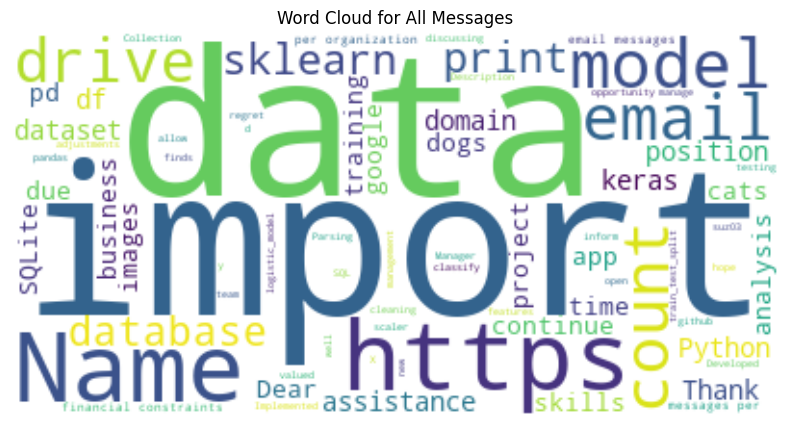

In [58]:
# Combine all messages into a single text for word cloud generation
text_all = " ".join(review for review in messages_df['Message'] if review != '<Media omitted>')
if len(text_all) > 0:
    # Generate word cloud for all messages
    wordcloud_all = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text_all)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_all, interpolation='bilinear')
    plt.axis("off")
    plt.title('Word Cloud for All Messages')
    plt.show()
else:
    print("No messages found to generate a word cloud.")


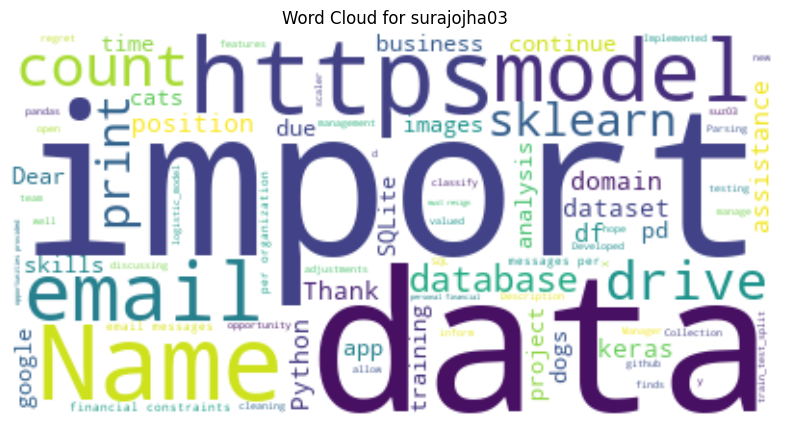

In [59]:
# Generate word clouds for each author
authors = messages_df['Author'].unique()
for author in authors:
    text_author = " ".join(review for review in messages_df[messages_df['Author'] == author]['Message'] if review != '<Media omitted>')
    if len(text_author) > 0:
        wordcloud_author = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text_author)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_author, interpolation='bilinear')
        plt.title(f'Word Cloud for {author}')
        plt.axis("off")
        plt.show()
    else:
        print(f"No messages found for {author} to generate a word cloud.")

In [60]:
# Display overall statistics
print("Total Media Messages:", media_messages_df.shape[0])
print("Total Emojis:", emojis)
print("Total Links:", links)


Total Media Messages: 33
Total Emojis: 0
Total Links: 12


In [61]:
# Individual statistics for each author
for author in authors:
    author_df = messages_df[messages_df['Author'] == author]
    print(f"\nStats for {author}:")
    print("Messages Sent:", author_df.shape[0])
    print("Average Words per Message:", author_df['Message'].apply(lambda s: len(s.split())).mean())
    print("Media Messages Sent:", media_messages_df[media_messages_df['Author'] == author].shape[0])
    print("Emojis Sent:", sum(author_df['Emojis'].apply(len)))
    print("Links Sent:", sum(author_df['Links']))


Stats for surajojha03:
Messages Sent: 31
Average Words per Message: 35.064516129032256
Media Messages Sent: 33
Emojis Sent: 0
Links Sent: 12
